In [1]:
import sys, os
sys.path.append(os.path.abspath("../src/"))

In [2]:
%reload_ext autoreload
%autoreload 2

import utils.dataset as dataset

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch

In [4]:
# LaTeX rendering in graphs
try:
    plt.rc('text', usetex=True)
except:
    pass

plt.rc('font', family='serif')

# High resolution graphs
%config InlineBackend.figure_format = 'retina'

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Some useful functions

In [8]:
def get_dataframe(run):
    data = pd.read_json('../logs/' + run + '.json', lines=True)
    data.set_index('epoch', inplace=True)
    data = pd.concat(
        [data.loc[data['phase'] == 'train'], data.loc[data['phase'] == 'valid']], 
        keys=['train', 'valid'], 
        axis=1
    )
    
    # We used to print epochs from 0 to n
    if data.index.values.min() == 0:
        data.index = [x + 1 if x == int(x) else x for x in data.index.values]
        data.sort_index(inplace=True)
    
    best_acc = data['valid', 'accuracy'].max() * 100
    best_acc_train = data['train', 'accuracy'].max() * 100
    
    print('Best train accuracy for {}: {:.2f}%'.format(run, best_acc_train))
    print('Best valid accuracy for {}: {:.2f}%'.format(run, best_acc))
    
    return data.drop('phase', axis=1, level=1)

In [7]:
def show_metric(data, metric, run='', save=False, window=1):
    plt.figure(figsize=(8, 5))
    
    for phase in ['train', 'valid']:
        d = data.xs([phase, metric], level=[0, 1], axis=1).dropna().rolling(window=window if phase == 'train' else 1).mean()
        
        if metric == 'accuracy':
            d *= 100
            
        plt.plot(d, label=phase)
    plt.legend()
    
    title = metric + ' for ' + run if len(run) > 0 else metric
    # plt.title(title)
    
    if metric == 'accuracy':
        plt.ylabel(r'Accuracy (\%)')
    else:
        plt.ylabel('Loss')
        
    plt.xlabel(r'Number of epochs')

    # plt.ylim(50, 100)
    
    if save:
        plt.savefig('outputs/' + run + '-' + metric + '.pdf', bbox_inches='tight')

# Exploring results

## CNN

In [10]:
run = 'cnn'

In [11]:
data = get_dataframe(run)

Best train accuracy for cnn: 100.00%
Best valid accuracy for cnn: 89.00%


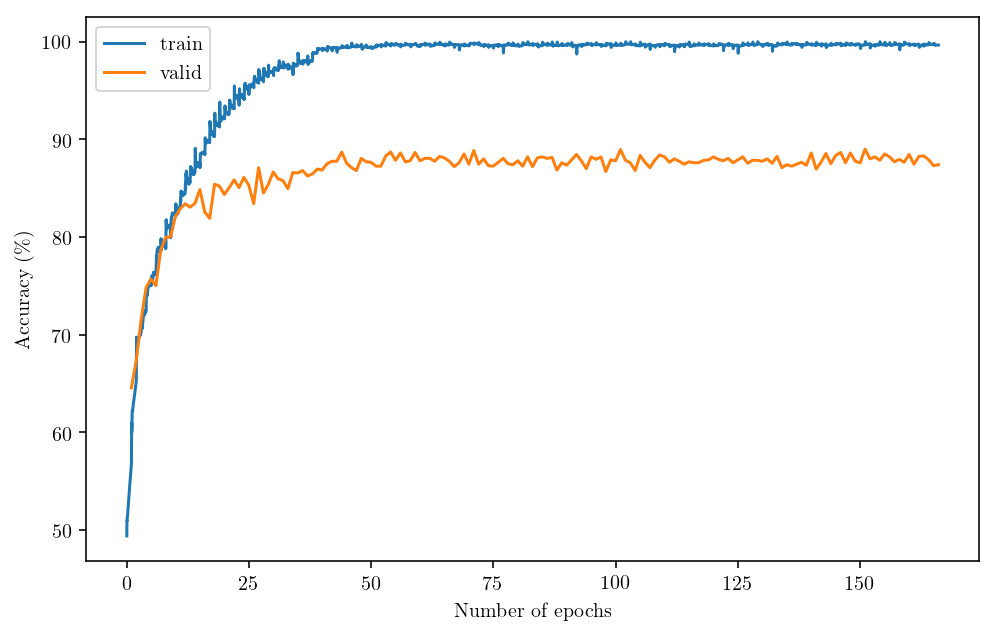

In [12]:
show_metric(data, 'accuracy', run, save=True, window=10)

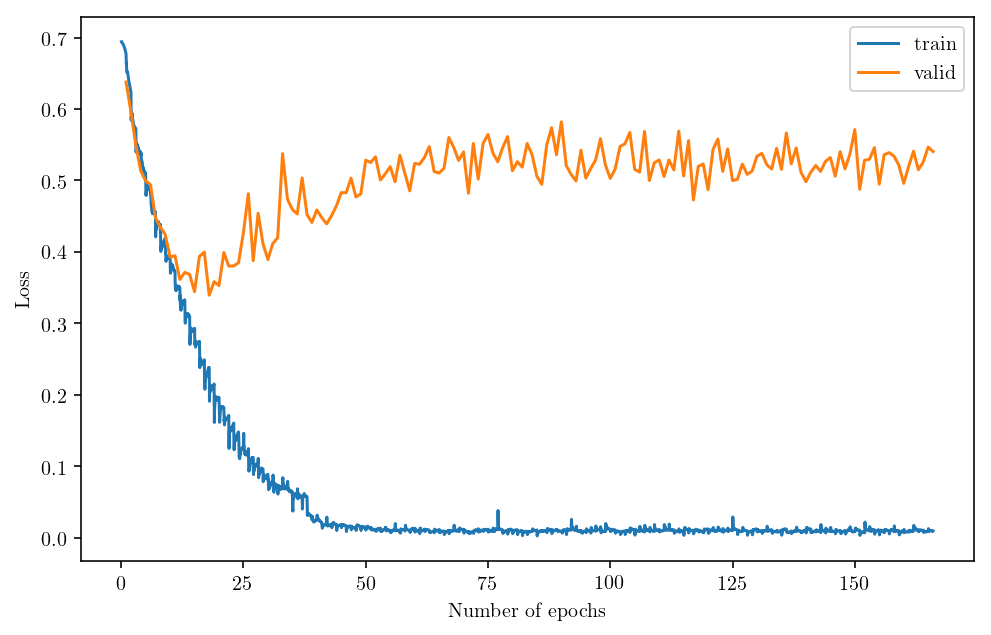

In [13]:
show_metric(data, 'loss', run, save=True, window=10)

Best train accuracy for baseline: 52.73%
Best valid accuracy for baseline: 50.35%
Best train accuracy for cnn-bs10-lr10-longer: 100.00%
Best valid accuracy for cnn-bs10-lr10-longer: 89.00%


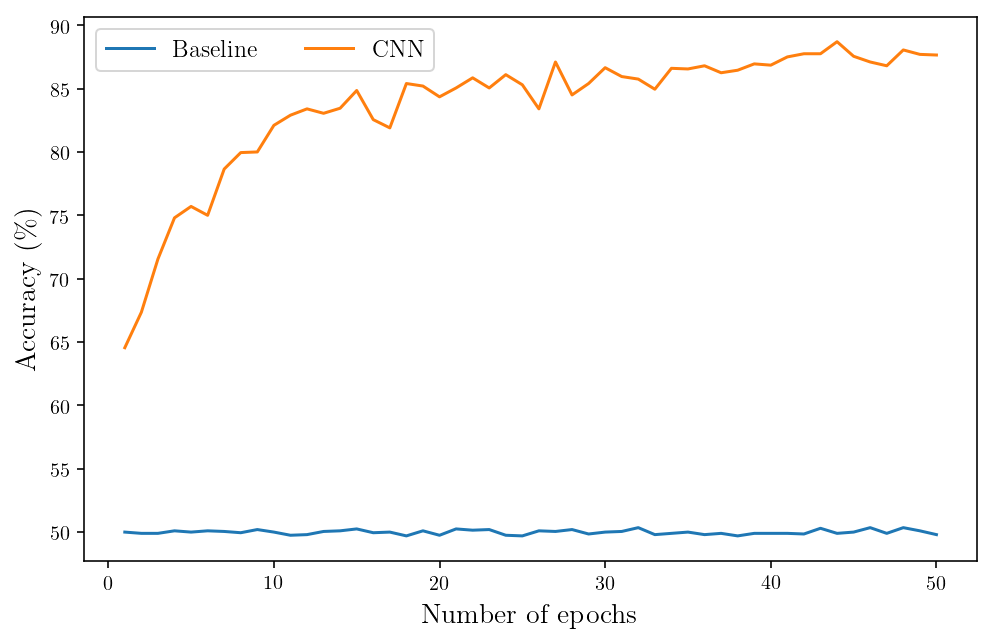

In [37]:
runs = ['baseline', 'cnn-bs10-lr10-longer']

labels = {
    'baseline': 'Baseline',
    'cnn-bs10-lr10-longer': 'CNN'
}

plt.figure(figsize=(8, 5))

for run in runs:
    data = get_dataframe(run)
    plt.plot(data.xs(['valid', 'accuracy'], level=[0, 1], axis=1).dropna().loc[:50]*100, label=labels[run])

plt.legend(fontsize=12, ncol=2)

plt.ylabel(r'Accuracy (\%)', size=14)
plt.xlabel(r'Number of epochs', size=14)

# plt.ylim(bottom=60, top=100)

plt.savefig('outputs/accuracies.pdf', bbox_inches='tight')